In [1]:
from fastai.vision.all import *

In [35]:
mimic_path = Path("/home/code-base/scratch_space/extra/physionet.org/files/mimic-cxr-jpg/2.0.0/")

In [36]:
Path.ls_names = lambda o: o.ls().map(lambda o: o.name)

In [38]:
mimic_path.ls_names()

(#9) ['SHA256SUMS.txt','mimic-cxr-2.0.0-split.csv.gz','mimic-cxr-2.0.0-metadata.csv.gz','README','index.html','mimic-cxr-2.0.0-negbio.csv.gz','files','LICENSE.txt','mimic-cxr-2.0.0-chexpert.csv.gz']

In [40]:
(mimic_path/"files").ls_names()

(#11) ['p18','p10','p12','p16','p17','index.html','p19','p15','p13','p11'...]

In [42]:
image_dirs = [o for o in (mimicpath/'files').ls() if o.name.startswith("p") and o.is_dir()]

In [115]:
image_dir = image_dirs[1]
patient_dirs = image_dir.ls().filter(lambda o: o.is_dir())
image_dir.name

'p10'

In [117]:
image_files = get_image_files(np.random.choice(patient_dirs))

In [119]:
imgs = [PILImage.create(o) for o in image_files]

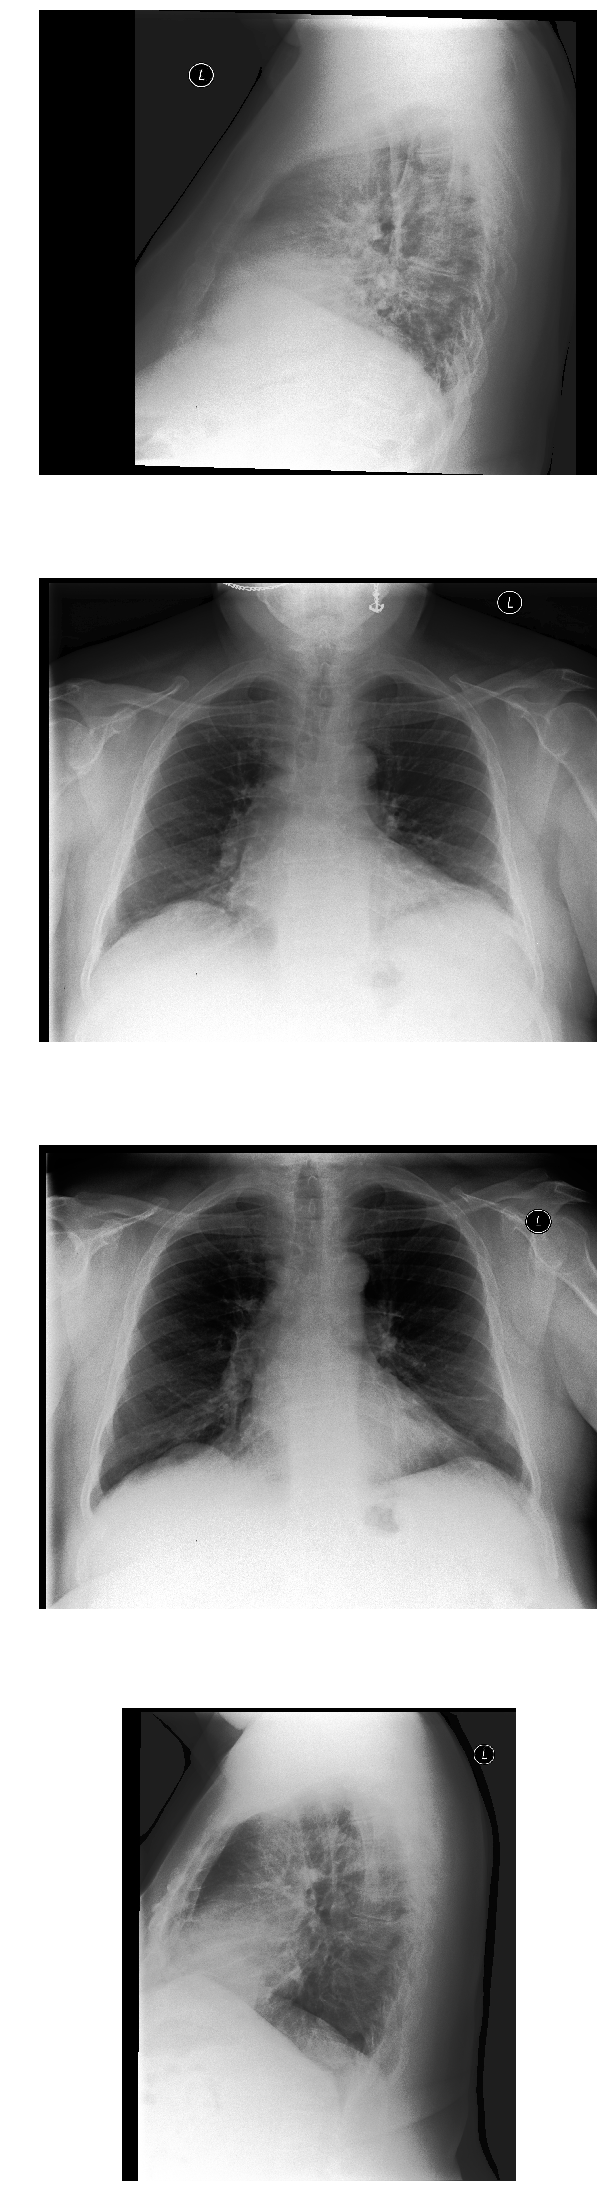

In [122]:
show_images(imgs, nrows=len(imgs), figsize=(10,len(imgs)*10))

In [107]:
cxr_reports_path = Path("/home/code-base/scratch_space/extra/mimic-cxr-reports/")

The dataset contains 377,110 images corresponding to 227,835 radiographic studies performed at the Beth Israel Deaconess Medical Center in Boston, MA.

In [109]:
cxr_reports = get_text_files(cxr_reports_path)

In [110]:
len(cxr_reports)

227835

In [136]:
report = open(np.random.choice(cxr_reports)).read()
print(report)

                                 FINAL REPORT
 INDICATION:  Epigastric abdominal pain.
 
 COMPARISON:  Chest radiographs from ___ and ___.
 
 FINDINGS: 
 
 Frontal and lateral chest radiographs demonstrate low lung volumes with
 prominence of the cardiac silhouette and bronchovascular crowding on frontal
 view.  There is bibasilar atelectasis, without identification of a definite
 focal consolidation.  There is no evidence of intraperitoneal free air. 
 Dilated loops of small bowel seen in the visualized upper abdomen are better
 evaluated on CT from the same day.  Calcification the anterior aspects of the
 vertebral bodies is consistent with DISH.
 
 IMPRESSION: 
 
 No acute cardiopulmonary process or evidence of intraperitoneal free air. 
 Dilated loops of small bowel in the visualized upper abdomen are better
 evaluated on CT from the same day.



#### Data Preprocessing 

**Images**

- Resize all jpeg files to 256 on the larger size

**Text**

- Tokenize all reports with english tokenizer from [CoreNLP](https://stanfordnlp.github.io/CoreNLP/)
- Keep only **Findings** and **Impression** section
- Remove image-text pair samples where number of tokens < 3
- Should have 217k image-text pairs

#### Pretraining ([MIMIC-CXR-II](https://physionet.org/content/mimic-cxr-jpg/2.0.0/))

- **Image Encoder:** ResNet-50
- **Text Encoder:** [ClinicalBERT](https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT). During contrastive training first 6 layers were frozen and only last 6 layers were trained.
    - https://allenai.github.io/scispacy/
- **Image Data Augmentations:** Random resized crop (0.6,1), hflip, affine tfms: rotation -+20 deg, horizontal-vertical translation 0.1, scaling (0.95,1.05), color jittering brightness and contrast from (0.6, 1.4) and gaussian blue (0.1,3), image size = 224
- **Text Data Augmentations:** Radomly sample a sentence from input document (probably after preprocessing).
- Hyperparameters; embed dim=512, tem=0.1 and loss weight=0.75 for pretraining selected by linear evaluation on RSNA image classification task with pretrained ResNet-50 weights.
- 5k validation during pretraining.
- bs = 32.

#### Downstream Tasks

- [RSNA](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview) - used as a binary classification task
- [Chexpert](https://stanfordmlgroup.github.io/competitions/chexpert/) - used expert labelled dataset as test set and a random 5,000 samples as validation 218414/5000/234 - only 234 samples in test
- [COVID-X](https://github.com/lindawangg/COVID-Net) - latest version
- [COVID-19 Radiography Database Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)

#### Ablation Ideas

- With/Without MLP during pretraining
- Use full text during pretraining
- Learnable temperature
- Linear evaluation or knn, which one is better and faster?

In [137]:
# !pip install transformers